In [1]:

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import wandb
from scipy.stats import norm
from torch import Tensor
from torch.utils.data import DataLoader

from nerf2d_dataset import read_image_folder, NeRFDataset2D, NeRF2D_Datamodule
from wandb_utils import get_artifact_dir_api
from wandb_utils import load_from_checkpoint_api

In [2]:
api = wandb.Api()
nerf = load_from_checkpoint_api(api, 'romeu/NeRF2D/model-5x9fjp84:v0').cpu()

wandb:   1 of 1 files downloaded.  


In [3]:
# read test set
dataset_folder = get_artifact_dir_api(api, 'romeu/NeRF2D/bunny:v0')
dm = NeRF2D_Datamodule(dataset_folder, 1, 1)

dataset = NeRFDataset2D(dm.val_ims, dm.val_poses, dm.val_focal, dm.val_depths)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

wandb:   406 of 406 files downloaded.  


In [4]:
def show_colors(colors, names=None):
    if names is None:
        names = [''] * len(colors)

    fig, ax = plt.subplots(1, len(colors), figsize=(len(colors), 1))
    for i, color in enumerate(colors):
        ax[i].imshow(color.expand(1, 1, 3).detach().numpy())
        ax[i].set_axis_off()
        ax[i].set_title(names[i])

    plt.show()

def get_nth_batch(n, loader):
    for i, batch in enumerate(loader):
        if i == n:
            return batch

tensor(1.)


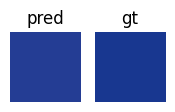

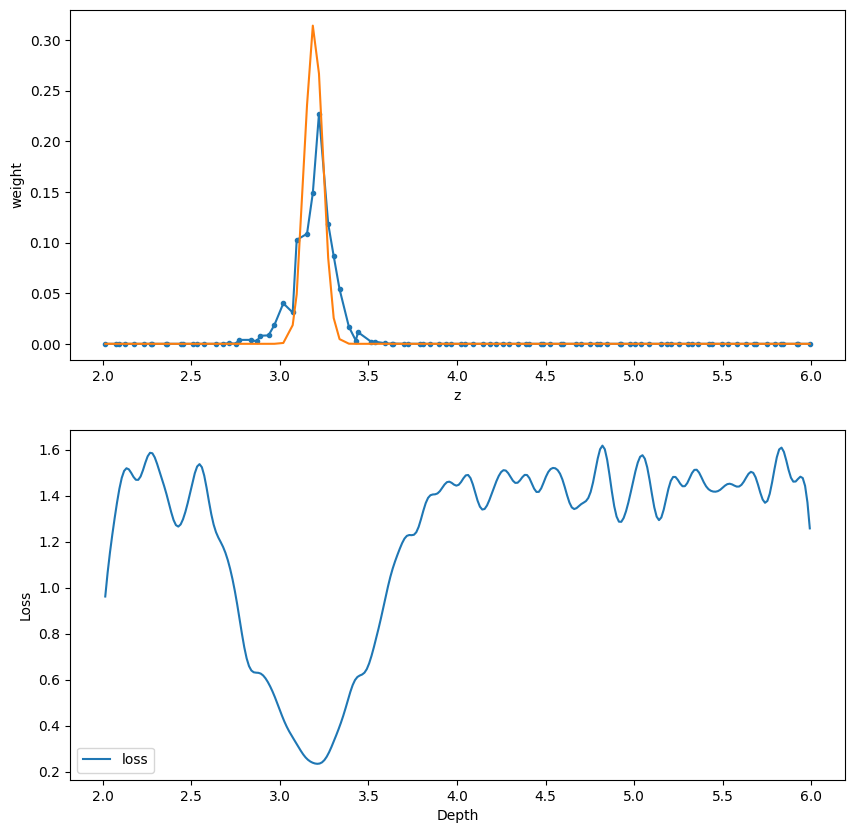

In [6]:
ray_idx = 40

# get dataset entry
o, d, color_gt, depth_gt = get_nth_batch(ray_idx, dataloader)

# nerf forward pass
with torch.no_grad():
    out = nerf(o, d)
    color_pred = out.colors
    weights = out.weights
    ts = out.ts

print(weights.sum())

# ray color
show_colors([color_pred[0], color_gt[0]], ['pred', 'gt'])

fig, (ax_weights, ax_gts) = plt.subplots(2, figsize=(10, 10))

# plot weights
ax_weights.plot(ts, weights[0], label='weights', marker='.')
ax_weights.set_xlabel('z')
ax_weights.set_ylabel('weight')

depths_lin = np.linspace(ts.min(), ts.max(), 300)

dists = ts[1:] - ts[:-1]
dist_pad = Tensor([dists.max()])

def discrete_gaussian_pdf(xs, sigma, loc):
    ps = norm.pdf(ts, scale=sigma, loc=loc)
    ps /= ps.sum()
    return Tensor(ps)

sigma = 0.05
ps = discrete_gaussian_pdf(ts, sigma, depth_gt.item())

dists = torch.cat([dists, dist_pad])

ax_weights.plot(ts, ps, label='gt')

# take loss for each gt depth
losses = []
kldivs = []
for gt_depth in depths_lin:
    loss = nerf.depth_loss(Tensor([gt_depth]), ts, weights, sigma)

    ps_gt = discrete_gaussian_pdf(ts, sigma, gt_depth).unsqueeze(0)

    eps = 1e-10
    weights_p = weights + eps
    weights_p = weights_p / weights_p.sum()

    ps_gt_p = ps_gt + eps
    ps_gt_p = ps_gt_p / ps_gt_p.sum()

    kl_div = F.kl_div(torch.log(weights_p), ps_gt_p, reduction='mean') * 50

    kldivs.append(kl_div.item())
    losses.append(loss.item())

# Plot the losses at the different depths
ax_gts.plot(depths_lin, losses, label='loss')
# ax_gts.plot(depths_lin, kldivs, label='kl_divs')
ax_gts.set_xlabel('Depth')
ax_gts.set_ylabel('Loss')
ax_gts.legend()

# ax_gts.set_ylim(0, 4)